# Interactias Geo Selected Network

One way of examining the impact of invasive species is to look at all their interactions and the interations those organisms have with each other. This full interaction network gives you an indication of whether a species might be a "keystone" species and therefore have a disproportionatly large impact.

In this step of the evolution of this script it will be adapted to quantify species by their occupancy.

I will harvest species interactions data from GloBI (https://www.globalbioticinteractions.org/) to discover the species that interact with an invasive species.
I will then harvest all the interactions for those species to create two tiers of interactions.
I will then count all the occurences of these in species in the Belgian datacube.
I will then visualize this.

This notebook takes considerable insperation and code from Yikang Li's project on GloBI (https://curiositydata.org/part1_globi_access/).


### For information: Invasive alien species of Union concern
|A|H|O|
|--|--|--|
|Acacia saligna|Herpestes javanicus|Pacifastacus leniusculus|
|Acridotheres tristis|Humulus scandens|Parthenium hysterophorus|
|Ailanthus altissima|Hydrocotyle ranunculoides|Pennisetum setaceum|
|Alopochen aegyptiaca|Impatiens glandulifera|Perccottus glenii|
|Alternanthera philoxeroides|Lagarosiphon major|Persicaria perfoliata|
|Andropogon virginicus|Lepomis gibbosus|Plotosus lineatus|
|Arthurdendyus triangulatus|Lespedeza cuneata|Procambarus clarkii|
|Asclepias syriaca|Lithobates catesbeianus|Procambarus fallax|
|Baccharis halimifolia|Ludwigia peploides|Procyon lotor|
|Cabomba caroliniana|Lygodium japonicum|Prosopis juliflora|
|Callosciurus erythraeus|Lysichiton americanus|Pseudorasbora parva|
|Cardiospermum grandiflorum|Microstegium vimineum|Pueraria montana|
|Cortaderia jubata|Muntiacus reevesi|Salvinia molesta|
|Corvus splendens|Myocastor coypus|Sciurus carolinensis|
|Ehrharta calycina|Myriophyllum aquaticum|Sciurus niger|
|Eichhornia crassipes|Myriophyllum heterophyllum|Tamias sibiricus|
|Elodea nuttallii|Nasua nasua|Threskiornis aethiopicus|
|Eriocheir sinensis|Nyctereutes procyonoides|Trachemys scripta|
|Gunnera tinctoria|Ondatra zibethicus|Triadica sebifera|
|Gymnocoronis spilanthoides|Orconectes limosus|Vespa velutina|
|Heracleum mantegazzianum|Orconectes virilis||
|Heracleum persicum|Oxyura jamaicensis||

In [1]:
import sys
print(sys.version)

#Python 3.7.4 (default, Aug 9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
#pygbif 0.3.0

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from pygbif import species
from pygbif import occurrences as occ
import sqlite3
from sqlite3 import Error
import pydot
import math

### Setting up some parameters

In [3]:
# There is no point accepting all the species that have more than one record.
# There are too many casual records of plants and birds
thresholdForOccNum = 5
# If you want to exclude an interaction add it here
#interactionsToExclude = "visitsFlowersOf" #If you're not intersted in pollinators this will remove most of them
interactionsToExclude = "interactsWith"    #Many interactions in GloBI do not specify a specific interaction. You can get a cleaner netwot by excluding them
interactionsToExclude = ""

In [4]:

## Define the country of interest
country  = 'Belgium'

## The occurrence cube has data for each year, but here we aggreagate years to get a more complete measure of occupancy.
## This parameter defines the year from where to consider records for the occupancy
year = 2000

## Define the place to find the data cube for occupancy data
## Currently the cube contains only Belgian data so that is all that can be used#
# A script to create cube.db is here https://github.com/AgentschapPlantentuinMeise/occcube
database = r"..\..\data\cube.db" 

## A script to create globi.db is here https://github.com/AgentschapPlantentuinMeise/createGlobiDB
## Define the place to find the interaction data
globiDB = r"..\..\createGlobiDB\globi.db"

### Define the taxon for the notebook for which to find all interactions


In [5]:
taxon=input()

Fraxinus excelsior


In [6]:
taxon = taxon.strip()

## Check to see if the taxon exits in GBIF

In [7]:
try:
    #NOTE: The function method name_suggest has a different behavior with regards to the gender of Latin names to name_backbone
    # If name_backbone is given a name in one gender it can still return the best match from the GBIF backbone if that
    # name is spelled as if it was another gender.
    #key = species.name_suggest(q=taxon, limit = 1)
    match = species.name_backbone(name=taxon, limit = 1)
    #print(key)
    
    # if there is no match this is returned form .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
    if match['matchType'] == 'NONE':
        raise ValueError("TAXON NOT FOUND ON GBIF!")
    else:
        key = match['usageKey']
except ValueError as ve:
    print(ve)
    exit(1)




In [8]:
fullScientificName = match['scientificName']
print('The taxon to be studied is ' + fullScientificName)


The taxon to be studied is Fraxinus excelsior L.


### Just for information take a look at the interactions that the taxon has

In [9]:
# What are all the types of interactions involving taxon as source taxon?
#data[data['sourceTaxonName'] == taxon]['interactionTypeName'].unique()
try:
    connGlobi = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [10]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName, COUNT(interactionTypeName) from globi  WHERE sourceTaxonSpeciesName = ? GROUP BY interactionTypeName;", (taxon,))
sourceInteractions = curGlobi.fetchall()

In [11]:
sourceInteractions

[('hasHost', 34), ('interactsWith', 223)]

In [12]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName, COUNT(interactionTypeName) from globi  WHERE targetTaxonSpeciesName = ? GROUP BY interactionTypeName;", (taxon,))
targetInteractions = curGlobi.fetchall()
targetInteractions

[('eats', 155),
 ('hasHost', 214),
 ('interactsWith', 540),
 ('livesOn', 2),
 ('parasiteOf', 30),
 ('pathogenOf', 13),
 ('preysOn', 18)]

## Get the primary interation data for the species in question

This is limited to the rank of species because otherwise the network can get very large with rather irrelivent higher taxa.
However, if no interactions are found at the species level it might be worth removing this restriction.

In [13]:
curGlobi = connGlobi.cursor()
#curGlobi.execute("SELECT * from globi  WHERE targetTaxonName = ? and interactionTypeName NOT IN (?);", \
if interactionsToExclude == "":
    curGlobi.execute("SELECT * from globi  WHERE targetTaxonSpeciesName = ?;", \
                 (taxon,))
else:
    curGlobi.execute("SELECT * from globi  WHERE targetTaxonSpeciesName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
interactDataTaxon = curGlobi.fetchall()

In [14]:
curGlobi = connGlobi.cursor()
#curGlobi.execute("SELECT * from globi  WHERE sourceTaxonName = ? and interactionTypeName NOT IN (?);", \
if interactionsToExclude == "":
    curGlobi.execute("SELECT * from globi  WHERE sourceTaxonSpeciesName = ?;", \
                 (taxon,))
else:
    curGlobi.execute("SELECT * from globi  WHERE sourceTaxonSpeciesName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
sources = curGlobi.fetchall()

In [15]:
interactDataTaxon.extend(sources)
len(interactDataTaxon)

1229

In [16]:
# Convert to a Pandas dataframe
interactDataTaxon = pd.DataFrame(interactDataTaxon)

In [17]:
# Add column names
interactDataTaxon
interactDataTaxon.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName', \
                                'sourceSexId', 'sourceSexName','interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName', 'targetSexId', 'targetSexName',\
                                'decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

## Get a list of all the primary interacting species

In [18]:
interactingTaxaData = interactDataTaxon.drop_duplicates()

In [19]:
primaryInteractingTaxa = interactingTaxaData['sourceTaxonName'].drop_duplicates()
len(primaryInteractingTaxa)

260

In [20]:
primaryInteractingTaxa = (primaryInteractingTaxa.append(interactingTaxaData['targetTaxonName']).drop_duplicates())
len(primaryInteractingTaxa)

275

In [21]:
primaryInteractingTaxa

0                      Anisoxya fuscula
1               Dorcus parallelipipedus
2                       Prionychus ater
3                 Paromalus flavicornis
4                       Hylastes opacus
5                           Valsa cypri
6                  Phyllactinia guttata
7                     Armillaria mellea
8                     Inonotus hispidus
9                    Peniophora cinerea
10                  Morchella esculenta
11                       Rhagium mordax
12                Trentepohlia abietina
13                   Platypus cylindrus
14                   Pleospora herbarum
15           Auricularia auricula-judae
16              Henningsomyces candidus
18               Heterobasidion annosum
20                    Abdera biflexuosa
21      Callistosporium luteo-olivaceum
22            Cytosporina millepunctata
23               Macrophya punctumalbum
24                  Orthotylus tenellus
25                  Anthocoris simulans
26                 Aulagromyza heringii


## A function to query the globi database

In [22]:
def secondaryDataInGlobi(conn, intaxon):
    cur = conn.cursor()
    if interactionsToExclude == "":
        cur.execute("SELECT * from globi  WHERE (targetTaxonSpeciesName = ? OR sourceTaxonSpeciesName = ?);", \
                 (intaxon,intaxon,))
    else:
        cur.execute("SELECT * from globi where (targetTaxonSpeciesName = ? OR sourceTaxonSpeciesName = ?) and interactionTypeName NOT IN (?);", \
                (intaxon,intaxon,interactionsToExclude,))
    return(cur.fetchall())

## Get all the secondary interactions

In [23]:
try:
    conn = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [24]:
secondarylist = []

for name in primaryInteractingTaxa:
    temp = secondaryDataInGlobi(conn, name)
    secondarylist.extend(temp)

In [25]:
# Convert to a Pandas dataframe
secondarylist = pd.DataFrame(secondarylist)

In [26]:
secondarylist.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName',\
                                'sourceSexId', 'sourceSexName', 'interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName', 'targetSexId', 'targetSexName', \
                                'decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

In [27]:
allInteractionsData = interactingTaxaData.append(secondarylist)

In [28]:
allInteractionsData = allInteractionsData.drop_duplicates()


In [29]:
    cleanInteractDataTaxon = allInteractionsData[['sourceTaxonId', 'sourceTaxonName', 'sourceTaxonSpeciesName', 'sourceTaxonRank',
        'sourceTaxonFamilyName', 'interactionTypeName',
        'targetTaxonName','targetTaxonSpeciesName','targetTaxonRank', 'sourceCitation', 'sourceDOI',
        'sourceTaxonKingdomName','sourceTaxonKingdomId', 'targetTaxonKingdomName','targetTaxonKingdomId'                                        
        ]].dropna(subset=['targetTaxonSpeciesName','sourceTaxonSpeciesName'])

In [30]:
allSourceInteractingTaxa = cleanInteractDataTaxon['sourceTaxonSpeciesName'].drop_duplicates()
allTargetInteractingTaxa = cleanInteractDataTaxon['targetTaxonSpeciesName'].drop_duplicates()

In [31]:
allInteractingTaxa = allSourceInteractingTaxa.append(allTargetInteractingTaxa).drop_duplicates()
allInteractingTaxa.count()

3012

In [32]:
allInteractingTaxa.head()

0           Anisoxya fuscula
1    Dorcus parallelipipedus
2            Prionychus ater
3      Paromalus flavicornis
4            Hylastes opacus
dtype: object

In [33]:
# How many different sort of interaction do I have left?
# Checking out all the interaction types
cleanInteractDataTaxon.groupby(cleanInteractDataTaxon['interactionTypeName']).size().sort_values(ascending = False)

interactionTypeName
interactsWith         10427
preysOn                8367
parasiteOf             5472
hasHost                3646
eats                   2586
pathogenOf              977
visitsFlowersOf         159
ectoparasiteOf          113
hasDispersalVector       79
hasVector                56
adjacentTo               44
livesInsideOf            23
endoparasitoidOf         23
livesOn                  22
endoparasiteOf           14
parasitoidOf             12
visits                   10
pollinates                8
symbiontOf                8
livesUnder                2
ectoParasitoid            2
farms                     1
kills                     1
dtype: int64

### This function takes a name string and checks on GBIF to see if the name exists there.

In [34]:
def speciesExistsInGBIF(name, rank):
    try:
        match = species.name_backbone(name=name, rank=rank, limit = 1)

        # if there is no match this is returned from .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
        if match['matchType'] == 'NONE':
            return False
        else:
            return match
    except ValueError as ve:
        print(ve)
        exit(1)

### Check that the species in question is actually found on GBIF

In [35]:
if(speciesExistsInGBIF(taxon, "species") == False):
    print("##### {0} has not been found on GBIF #####".format(taxon))

### Citation for the GBIF Backbone Taxonomy

In [36]:
from datetime import date
print("GBIF Secretariat (2019). GBIF Backbone Taxonomy. Checklist dataset https://doi.org/10.15468/39omei accessed via GBIF.org on ", date.today())

GBIF Secretariat (2019). GBIF Backbone Taxonomy. Checklist dataset https://doi.org/10.15468/39omei accessed via GBIF.org on  2020-11-22


### Check to see which taxa in the interaction network are found in GBIF and list those ones that are not

In [37]:
taxaFound = {}
kingdom = {}

print('Taxa from GLoBI, but not found in GBIF')
for name in allInteractingTaxa.items():
    GBIFName = speciesExistsInGBIF(name[1], "species")
    if GBIFName == False:
        taxaFound[name[1]] = False
        print(name[1])
    else:
        taxaFound[name[1]] = GBIFName['usageKey']
        kingdom[name[1]] = GBIFName['kingdom']

    

Taxa from GLoBI, but not found in GBIF

Salix alba
Pseudomonas phage
Parus major densovirus
Plasmodium polare
Leucocytozoon majoris
Nectria coccinea
Operophtera brumata reovirus
Operophtera brumata nucleopolyhedrovirus
NPV
New
Prairie vole hantavirus
Sin
New York virus
Vesicular stomatitis Indiana virus
Whitewater Arroyo virus
Trypanosoma peromysci
Hymenolepis folkertsi
Eimeria arizonensis
Eimeria langebarteli
Eimeria peromysci
Neospylla faceta
Sin Nombre virus
Ljungan virus 64-7855
Prospect Hill virus
Colletotrichum gloeosporioides chrysovirus
Pseudomonas virus tabernarius
Pseudomonas phage PPPL-1
Pseudomonas phage phiPsa374
Pseudomonas phage phiPSA2
Pseudomonas phage phiPSA1
Pseudomonas phage phi8
Pseudomonas phage phi2954
Pseudomonas phage phi13
Pseudomonas phage phi12
Pseudomonas virus nickie
Pseudomonas phage Andromeda
Digitalis purpurea
Ficus religiosa
Ficus carica
Bat paramyxovirus
Swine acute diarrhea syndrome related coronavirus
Bat coronavirus
Bat coronavirus/4702/2013/Cynomo

In [38]:
# Convert to a Pandas dataframe
taxaFound = pd.DataFrame.from_dict(taxaFound, orient='index')

In [39]:
len(taxaFound)

3012

In [40]:
kingdom

{'Anisoxya fuscula': 'Animalia',
 'Dorcus parallelipipedus': 'Animalia',
 'Prionychus ater': 'Animalia',
 'Paromalus flavicornis': 'Animalia',
 'Hylastes opacus': 'Animalia',
 'Valsa cypri': 'Fungi',
 'Phyllactinia guttata': 'Fungi',
 'Armillaria mellea': 'Fungi',
 'Inonotus hispidus': 'Fungi',
 'Peniophora cinerea': 'Fungi',
 'Morchella esculenta': 'Fungi',
 'Rhagium mordax': 'Animalia',
 'Trentepohlia abietina': 'Plantae',
 'Platypus cylindrus': 'Animalia',
 'Pleospora herbarum': 'Fungi',
 'Auricularia auricula-judae': 'Fungi',
 'Henningsomyces candidus': 'Fungi',
 'Heterobasidion annosum': 'Fungi',
 'Abdera biflexuosa': 'Animalia',
 'Callistosporium luteo-olivaceum': 'Fungi',
 'Cytosporina': 'Fungi',
 'Macrophya punctumalbum': 'Animalia',
 'Orthotylus tenellus': 'Animalia',
 'Anthocoris simulans': 'Animalia',
 'Aulagromyza heringii': 'Animalia',
 'Sinodendron cylindricum': 'Animalia',
 'Orthotylus nassatus': 'Animalia',
 'Lytta vesicatoria': 'Animalia',
 'Diaporthe samaricola': 'Fun

### This function takes a GBIF species key and counts how many occurences exist in the data cube

In [41]:
def speciesCountInCube(conn, key):
    cur = conn.cursor()
    cur.execute("SELECT COUNT(taxonKey) from (SELECT taxonKey FROM cube WHERE year > ? and taxonKey = ? GROUP BY eea_cell_code)", (year, key,))
    return(cur.fetchall())

### Loop over all the taxa that are in the interaction network and are in GBIF to find the ones that have been found in the country

In [42]:
taxaFoundInCountry = []

try:
    conn = sqlite3.connect(database)
except Error as e:
    print(e)

In [43]:
year

2000

In [44]:
for GBIFtaxon in taxaFound.iterrows():
    GBIFOccCount = speciesCountInCube(conn, GBIFtaxon[1][0])
    print(GBIFtaxon[0])
    if GBIFOccCount[0][0] > thresholdForOccNum and GBIFtaxon[0] != taxon: # The threshold for observations is not greater than one, due to all the casual records
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))
    elif GBIFtaxon[0] == taxon:
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))

Anisoxya fuscula
Dorcus parallelipipedus
Dorcus parallelipipedus with key 5743112 occurs in 97 km squares.
Prionychus ater
Paromalus flavicornis
Paromalus flavicornis with key 4433174 occurs in 19 km squares.
Hylastes opacus
Valsa cypri
Phyllactinia guttata
Armillaria mellea
Inonotus hispidus
Peniophora cinerea
Morchella esculenta
Rhagium mordax
Rhagium mordax with key 9128025 occurs in 84 km squares.
Trentepohlia abietina
Platypus cylindrus
Platypus cylindrus with key 1205228 occurs in 89 km squares.
Pleospora herbarum
Auricularia auricula-judae
Auricularia auricula-judae with key 5249271 occurs in 17 km squares.
Henningsomyces candidus
Heterobasidion annosum
Abdera biflexuosa
Callistosporium luteo-olivaceum
Cytosporina
Macrophya punctumalbum
Macrophya punctumalbum with key 4490449 occurs in 39 km squares.
Orthotylus tenellus
Orthotylus tenellus with key 4488049 occurs in 8 km squares.
Anthocoris simulans
Aulagromyza heringii
Sinodendron cylindricum
Sinodendron cylindricum with key 44

Alnus glutinosa
Alnus glutinosa with key 2876213 occurs in 6903 km squares.
Hedera helix
Hedera helix with key 8351737 occurs in 7040 km squares.
Syringa vulgaris
Syringa vulgaris with key 5415039 occurs in 1350 km squares.
Aesculus hippocastanum
Aesculus hippocastanum with key 3189815 occurs in 1857 km squares.
Buxus sempervirens
Buxus sempervirens with key 2984671 occurs in 43 km squares.
Olearia avicenniifolia
Rheum x hybridum
Davidia involucrata
Euonymus japonicus
Euonymus japonicus with key 7102937 occurs in 31 km squares.
Garrya elliptica
Arundo donax
Arundo donax with key 2703041 occurs in 6 km squares.
Allium cepa
Allium cepa with key 2857697 occurs in 16 km squares.
Collybia cookei
Lasiosphaeria ovina
Prunus lusitanica
Prunus lusitanica with key 3020871 occurs in 47 km squares.
Cydonia oblonga
Cydonia oblonga with key 5362215 occurs in 52 km squares.
Crataegus laevigata
Crataegus laevigata with key 8252683 occurs in 911 km squares.
Prunus simonii
Malus domestica
Prunus lauroce

Turdus iliacus
Turdus iliacus with key 2490781 occurs in 11112 km squares.
Turdus merula
Turdus merula with key 2490719 occurs in 15453 km squares.
Erithacus rubecula
Erithacus rubecula with key 2492462 occurs in 14444 km squares.
Turdus philomelos
Turdus philomelos with key 7901064 occurs in 13947 km squares.
Ferdinandea cuprea
Phaonia gobertii
Xylotachina diluta
Brachyopa insensilis
Ferdinandea ruficornis
Phaonia pratensis
Phaonia laeta
Fannia aequilineata
Nosema cossi
Fraxinus ornus
Fraxinus ornus with key 3172347 occurs in 67 km squares.
Cercobelus jugaeus
Pediobius chylizae
Balcha indica
Phasgonophora sulcata
Eupelmus pini
Oobius primorskyensis
Oobius agrili
Zaischnopsis bouceki
Eupelmus annulatus
Cordyceps
Isaria
Paecilomyces lilacinus
Staphylocystis pistillum
Trogulus tricarinatus
Strigamia acuminata
Geophilus flavus
Schendyla nemorensis
Geophilus insculptus
Geophilus ribauti
Lithobius dentatus
Lithobius piceus
Lithobius crassipes
Polydesmia pruinosa
Perilampus aeneus
Metacolus 

Aonidiella aurantii
Macrophoma taxi
Pseudobaeospora laguncularis
Phlebiella sulphurea
Leucoagaricus badhamii
Hypochniciellum subillaqueatum
Hymenogaster vulgaris
Dendrothele amygdalispora
Dacrymyces estonicus
Clavaria purpurea
Sporidesmiella longissima
Sporidesmiella claviformis
Nectria ralfsii
Melanopsammella preussii
Chalara cylindrica
Blastobasis adustella
Myrsine australis
Hemiphaga novaeseelandiae
Danaus plexippus
Mesopolobus diffinis
Torymus nigritarsus
Mesopolobus aspilus
Aprostocetus taxi
Eupithecia miserulata
Hedya pruniana
Ditula angustiorana
Dinychus perforatus
Urodiaspis tecta
Urodiaspis pannonica
Sorex fumeus
Napaeozapus insignis
Blarina brevicauda
Turdus torquatus
Turdus torquatus with key 7865305 occurs in 4141 km squares.
Sturnus vulgaris
Sturnus vulgaris with key 9809229 occurs in 14454 km squares.
Coccothraustes coccothraustes
Coccothraustes coccothraustes with key 2494329 occurs in 7112 km squares.
Cyanistes caeruleus
Cyanistes caeruleus with key 2487879 occurs in 14

Ero furcata
Ero furcata with key 2167496 occurs in 78 km squares.
Porrhomma microphthalmum
Porrhomma microphthalmum with key 2135388 occurs in 35 km squares.
Walckenaeria dysderoides
Walckenaeria dysderoides with key 2134791 occurs in 91 km squares.
Pterostichus strenuus
Pterostichus strenuus with key 7508714 occurs in 11 km squares.
Linyphia hortensis
Linyphia hortensis with key 2136628 occurs in 123 km squares.
Palliduphantes pallidus
Palliduphantes pallidus with key 2135758 occurs in 462 km squares.
Tenuiphantes tenebricola
Tenuiphantes tenebricola with key 2135968 occurs in 202 km squares.
Brigittea latens
Brigittea latens with key 8267901 occurs in 60 km squares.
Ballus chalybeius
Ballus chalybeius with key 2170221 occurs in 48 km squares.
Domene scabricollis
Stenus fuscicornis
Walckenaeria atrotibialis
Walckenaeria atrotibialis with key 2134829 occurs in 625 km squares.
Tenuiphantes mengei
Tenuiphantes mengei with key 2135969 occurs in 550 km squares.
Lithobius calcaratus
Robertu

Malva sylvestris
Malva sylvestris with key 3152374 occurs in 3570 km squares.
Hepatica nobilis
Ribes alpinum
Ribes alpinum with key 2986184 occurs in 90 km squares.
Doronicum pardalianches
Doronicum pardalianches with key 3142951 occurs in 10 km squares.
Convallaria majalis
Convallaria majalis with key 7459480 occurs in 2497 km squares.
Clinopodium vulgare
Clinopodium vulgare with key 2926945 occurs in 461 km squares.
Erysimum humile
Leucanthemum vulgare
Leucanthemum vulgare with key 8848598 occurs in 6156 km squares.
Leucanthemum ×
Centaurea nigra
Centaurea nigra with key 3128225 occurs in 108 km squares.
Galium odoratum
Galium odoratum with key 2914642 occurs in 471 km squares.
Aristolochia clematitis
Aristolochia clematitis with key 2873991 occurs in 35 km squares.
Elymus repens
Elymus repens with key 5290299 occurs in 4817 km squares.
Hydrocotyle vulgaris
Hydrocotyle vulgaris with key 3034606 occurs in 2134 km squares.
Septoria
Hoya carnosa
Populus balsamifera
Populus balsamifera w

Allium oleraceum
Allium oleraceum with key 2857071 occurs in 43 km squares.
Juniperus oxycedrus
Mycosphaerella tassiana
Asparagus officinalis
Asparagus officinalis with key 2768885 occurs in 1049 km squares.
Artemisia vulgaris
Artemisia vulgaris with key 3120946 occurs in 7482 km squares.
Psila caucasica
Securigera varia
Securigera varia with key 5350000 occurs in 307 km squares.
Astragalus onobrychioides
Amorpha fruticosa
Amorpha fruticosa with key 5357407 occurs in 22 km squares.
Spartium junceum
Spartium junceum with key 5355395 occurs in 20 km squares.
Trifolium alexandrinum
Trifolium alexandrinum with key 5358907 occurs in 43 km squares.
Hedysarum coronarium
Cicer arietinum
Cotoneaster insignis
Thalictrum minus
Thalictrum minus with key 3033129 occurs in 248 km squares.
Salsola kali
Lepidium sativum
Lepidium sativum with key 5376565 occurs in 50 km squares.
Lepidium perfoliatum
Lepidium perfoliatum with key 5376816 occurs in 7 km squares.
Armoracia rusticana
Armoracia rusticana wi

Aglais urticae
Aglais urticae with key 1894840 occurs in 12240 km squares.
Anthophila fabriciana
Anthophila fabriciana with key 5123461 occurs in 6 km squares.
Notocelia uddmanniana
Cydia pomonella
Cydia pomonella with key 1737847 occurs in 8 km squares.
Loxostege sticticalis
Gossypium hirsutum
Earias insulana
Pegomya hyoscyami
Salix barclayi
Chrysops aestuans
Sepedon fuscipennis
Trichoplusia ni
Rhynchites auratus
Saccharum officinarum
Swine acute diarrhea syndrome related coronavirus
Achaea janata
Corcyra cephalonica
Phthorimaea operculella
Chilo infuscatellus
Lacanobia oleracea
Lacanobia oleracea with key 1759083 occurs in 9 km squares.
Pieris rapae
Pieris rapae with key 1920496 occurs in 14956 km squares.
Sialis lutaria
Sialis lutaria with key 5101313 occurs in 836 km squares.
Sialis infumata
Ricinus communis
Ricinus communis with key 5380041 occurs in 10 km squares.
Oryza sativa
Chrysops mitis
Chrysops excitans
Chrysops univittatus
Chrysops striatus
Chauliodes rastricornis
Tabanus 

Sonchus arvensis
Sonchus arvensis with key 3105813 occurs in 3331 km squares.
Liriomyza congesta
Liriomyza sativae
Ilex crenata
Ilex crenata with key 5414239 occurs in 44 km squares.
Thalictrum aquilegiifolium
Thalictrum aquilegiifolium with key 3033131 occurs in 15 km squares.
Phytomyza ranunculi
Phytomyza jucunda
Aulagromyza tridentata
Phytomyza vitalbae
Chromatomyia lonicerae
Liriomyza strigata
Pisum sativum
Pisum sativum with key 5347845 occurs in 115 km squares.
Milium effusum
Milium effusum with key 2706196 occurs in 1574 km squares.
Aulagromyza populi
Aulagromyza hendeliana
Agromyza demeijerei
Chromatomyia milii
Calycomyza artemisiae
Alopecurus myosuroides
Alopecurus myosuroides with key 5290097 occurs in 1349 km squares.
Phytomyza atricornis
Prunus dulcis
Palaeocimbex quadrimaculatus
Stigmella roborella
Jacaranda mimosifolia
Phytoliriomyza jacarandae
Phytomyza heringiana
Chromatomyia syngenesiae
Exoteleia dodecella
Leucoptera laburnella
Bat coronavirus
Nepticula juglandifoliell

Neuroterus numismalis
Neuroterus numismalis with key 1309691 occurs in 926 km squares.
Neuroterus quercusbaccarum
Neuroterus quercusbaccarum with key 1309692 occurs in 1170 km squares.
Neuroterus albipes
Neuroterus albipes with key 4496799 occurs in 894 km squares.
Neuroterus anthracinus
Neuroterus anthracinus with key 4496851 occurs in 454 km squares.
Neuroterus tricolor
Neuroterus tricolor with key 4496820 occurs in 14 km squares.
Dryocosmus cerriphilus
Dryocosmus kuriphilus
Dryocosmus kuriphilus with key 1309652 occurs in 419 km squares.
Pseudoneuroterus macropterus
Andricus corruptrix
Andricus corruptrix with key 4497120 occurs in 42 km squares.
Andricus amenti
Dendrolimus pini
Dasineura gleditchiae
Stereonychus fraxini
Cyamopsis tetragonoloba
Megastigmus pistaciae
Vigna unguiculata
Melanagromyza phaseoli
Scolytus
Celticecis japonica
Ceratitis capitata
Archarius vicetinus
Mikiola fagi
Mikiola fagi with key 1594607 occurs in 15 km squares.
Andricus aestivalis
Zelkova serrata
Zelkova

Cornus controversa
Rubus chamaemorus
Salix interior
Ailanthus altissima
Ailanthus altissima with key 3190653 occurs in 576 km squares.
Aesculus flava
Acer spicatum
Decodon verticillatus
Crataegus tomentosa
Crataegus parvifolia
Crataegus mollis
Crataegus intricata
Crataegus calpodendron
Cotoneaster monopyrenus
Cotinus obovatus
Corylus cornuta
Juniperus procumbens
Hamamelis virginiana
Halesia carolina
Ginkgo biloba
Ginkgo biloba with key 2687885 occurs in 55 km squares.
Malus atrosanguinea
Malus arnoldiana
Malus adstringens
Prunus americana
Populus deltoides
Populus deltoides with key 3040232 occurs in 10 km squares.
Ribes americanum
Rhus typhina
Rhus typhina with key 3190538 occurs in 639 km squares.
Rhus glabra
Tilia euchlora
Taxus X
Taxodium distichum
Taxodium distichum with key 2684191 occurs in 73 km squares.
Syringa chinensis
Symphoricarpos albus
Symphoricarpos albus with key 7523753 occurs in 1956 km squares.
Spiraea tomentosa
Spiraea tomentosa with key 3026819 occurs in 19 km squ

Digitaria sanguinalis
Digitaria sanguinalis with key 5289972 occurs in 2057 km squares.
Albizia julibrissin
Catalpa speciosa
Trichoderma
Desmodium adscendens
Pinus mugo
Coptotermes formosanus
Alternanthera philoxeroides
Synedrella nodiflora
Araucaria angustifolia
Saraca asoca
Grevillea robusta
Ammophila arenaria
Ammophila arenaria with key 5289845 occurs in 405 km squares.
Arabidopsis thaliana
Arabidopsis thaliana with key 3052436 occurs in 3789 km squares.
Nicotiana benthamiana
Caenorhabditis elegans
Averrhoa carambola
Helianthus tuberosus
Helianthus tuberosus with key 3119175 occurs in 268 km squares.
Spinacia oleracea
Spinacia oleracea with key 3083647 occurs in 23 km squares.
Carthamus tinctorius
Carthamus tinctorius with key 3138327 occurs in 63 km squares.
Calceolaria crenatiflora
Allium sativum
Beta vulgaris
Beta vulgaris with key 8971274 occurs in 174 km squares.
Zizania palustris
Lycopersicon esculentum
Lycopersicon esculentum with key 9608998 occurs in 7 km squares.
Ambrosia 

In [45]:
# Convert to a Pandas dataframe
taxaFoundInCountry = pd.DataFrame(taxaFoundInCountry)    

In [46]:
print("The number of species left in the network is {0}".format(len(taxaFoundInCountry)))

The number of species left in the network is 671


In [47]:
taxaFoundInCountry

,count,key,species
0,97,5743112,Dorcus parallelipipedus
1,19,4433174,Paromalus flavicornis
2,84,9128025,Rhagium mordax
3,89,1205228,Platypus cylindrus
4,17,5249271,Auricularia auricula-judae
5,39,4490449,Macrophya punctumalbum
6,8,4488049,Orthotylus tenellus
7,55,4425587,Sinodendron cylindricum
8,19,8323161,Stenocorus meridianus
9,6,1730978,Zeuzera pyrina


## Drawing a network of the interactions

Now that I have a list of all the species in the country I can use this as my nodes list for the network diagram.

In [48]:
#networkx seems to be a leading network tool in Python
import networkx as nx
import matplotlib.pyplot as plt

try:
    import pygraphviz
    from networkx.drawing.nx_agraph import write_dot
    print("using package pygraphviz")
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import write_dot
        print("using package pydot")
    except ImportError:
        print()
        print("Both pygraphviz and pydot were not found ")
        print("see  https://networkx.github.io/documentation/latest/reference/drawing.html")
        print()

using package pydot


In [49]:
# Create graphic object
G = nx.DiGraph()

In [50]:
# Match colours to interactions to distinguish them on the graph
colorInteractions = {'interaction':['pollinates', 'mutualistOf', 'eats', 'visitsFlowersOf', 'hasHost', 'parasiteOf', 'pathogenOf'],
        'colour':['r', 'g', 'b', 'y', 'm', 'w', 'c']}  

colorInteractionsDf = pd.DataFrame(colorInteractions)

#len(list(G.nodes))

## A quick look at the interaction data to see if it is what is expected

In [51]:
#cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonName"] == 'Apis mellifera') & (cleanInteractDataTaxon["targetTaxonName"] == 'Procyon lotor')]
cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonSpeciesName"] == 'Bombus hortorum')]

,sourceTaxonId,sourceTaxonName,sourceTaxonSpeciesName,sourceTaxonRank,sourceTaxonFamilyName,interactionTypeName,targetTaxonName,targetTaxonSpeciesName,targetTaxonRank,sourceCitation,sourceDOI,sourceTaxonKingdomName,sourceTaxonKingdomId,targetTaxonKingdomName,targetTaxonKingdomId


## Figure out which node has the most records. This is so that the graphic can be scaled.

In [52]:
if len(taxaFoundInCountry) > 0:
    maxRecords = taxaFoundInCountry.max()["count"]
    print(maxRecords)

15535


### Add the nodes to the graph

In [53]:
dictOfNodeSizes = {}

for index, row in taxaFoundInCountry.iterrows():
     # access data using column names
    #print('A: ', row['species'], row['count'], row['key'])
    G.add_node(row['species'], gbifkey=row['key'], occupancy = row['count'])
    #create a list of node sizes scaled for the network visulization
    #The square root ensures that the node area is proportional to the occupancy, rather than the radius
    dictOfNodeSizes[row['species']] = math.sqrt(int(row['count']/maxRecords*100))*10

### Add edges to the graph

In [54]:
# iterate over the interacting species that are in GBIF and in the country with iterrows()
# Find the taxa found in the country that are in the source taxon name of the interation data,
# then add the edge if the target species is in the country too.

taxaFoundInCountry_copy = taxaFoundInCountry.copy()

for index, row in taxaFoundInCountry.iterrows():
    # loop over all the taxa finding if any of them are mentioned in the sourceTaxonName field
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['sourceTaxonSpeciesName']:
            #print('B: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            # Some of the target species will not be in GBIF of in the country, so only add an edge where they are.
            for index2, row2 in taxaFoundInCountry_copy.iterrows():
                #print('E: ', row2['species'], edge[1]['targetTaxonName'])
                if row2['species'] == edge[1]['targetTaxonSpeciesName']: 
                    print('C: ', edge[1]['targetTaxonSpeciesName'], row['species'], edge[1]['interactionTypeName'])
                    G.add_edge(row['species'], edge[1]['targetTaxonSpeciesName'], label = edge[1]['interactionTypeName'])
                    
#len(list(G.nodes))


C:  Fraxinus excelsior Dorcus parallelipipedus interactsWith
C:  Fraxinus excelsior Dorcus parallelipipedus interactsWith
C:  Fraxinus excelsior Dorcus parallelipipedus eats
C:  Fraxinus excelsior Dorcus parallelipipedus eats
C:  Fraxinus excelsior Dorcus parallelipipedus eats
C:  Fraxinus excelsior Dorcus parallelipipedus interactsWith
C:  Aeletes atomarius Dorcus parallelipipedus interactsWith
C:  Plegaderus dissectus Dorcus parallelipipedus interactsWith
C:  Fagus sylvatica Dorcus parallelipipedus interactsWith
C:  Aeletes atomarius Dorcus parallelipipedus interactsWith
C:  Plegaderus dissectus Dorcus parallelipipedus interactsWith
C:  Fagus sylvatica Dorcus parallelipipedus interactsWith
C:  Fagus sylvatica Dorcus parallelipipedus eats
C:  Prunus cerasifera Dorcus parallelipipedus eats
C:  Ulmus glabra Dorcus parallelipipedus eats
C:  Carpinus betulus Dorcus parallelipipedus eats
C:  Fagus sylvatica Dorcus parallelipipedus eats
C:  Aeletes atomarius Dorcus parallelipipedus interact

C:  Fraxinus excelsior Sinodendron cylindricum interactsWith
C:  Fraxinus excelsior Sinodendron cylindricum interactsWith
C:  Fraxinus excelsior Sinodendron cylindricum eats
C:  Fraxinus excelsior Sinodendron cylindricum eats
C:  Fraxinus excelsior Sinodendron cylindricum eats
C:  Fraxinus excelsior Sinodendron cylindricum interactsWith
C:  Castanea sativa Sinodendron cylindricum interactsWith
C:  Fagus sylvatica Sinodendron cylindricum interactsWith
C:  Castanea sativa Sinodendron cylindricum interactsWith
C:  Fagus sylvatica Sinodendron cylindricum interactsWith
C:  Castanea sativa Sinodendron cylindricum livesInsideOf
C:  Castanea sativa Sinodendron cylindricum livesInsideOf
C:  Fagus sylvatica Sinodendron cylindricum eats
C:  Castanea sativa Sinodendron cylindricum eats
C:  Fagus sylvatica Sinodendron cylindricum eats
C:  Castanea sativa Sinodendron cylindricum eats
C:  Tilia cordata Sinodendron cylindricum eats
C:  Corylus avellana Sinodendron cylindricum eats
C:  Acer platanoides

C:  Castanea sativa Cossus cossus eats
C:  Castanea sativa Cossus cossus eats
C:  Fraxinus excelsior Hymenoscyphus pseudoalbidus pathogenOf
C:  Fraxinus excelsior Hymenoscyphus pseudoalbidus pathogenOf
C:  Fraxinus excelsior Hymenoscyphus pseudoalbidus pathogenOf
C:  Fraxinus excelsior Hymenoscyphus pseudoalbidus pathogenOf
C:  Fraxinus excelsior Hymenoscyphus pseudoalbidus pathogenOf
C:  Fraxinus excelsior Hymenoscyphus pseudoalbidus pathogenOf
C:  Fraxinus excelsior Hymenoscyphus pseudoalbidus pathogenOf
C:  Fraxinus angustifolia Hymenoscyphus pseudoalbidus pathogenOf
C:  Fraxinus angustifolia Hymenoscyphus pseudoalbidus pathogenOf
C:  Fraxinus angustifolia Hymenoscyphus pseudoalbidus pathogenOf
C:  Fraxinus angustifolia Hymenoscyphus pseudoalbidus pathogenOf
C:  Fraxinus angustifolia Hymenoscyphus pseudoalbidus pathogenOf
C:  Fraxinus angustifolia Hymenoscyphus pseudoalbidus pathogenOf
C:  Fraxinus excelsior Hylesinus varius eats
C:  Fraxinus excelsior Hylesinus varius eats
C:  Frax

C:  Arytaina genistae Fringilla coelebs preysOn
C:  Arytaina genistae Fringilla coelebs eats
C:  Arytaina genistae Fringilla coelebs eats
C:  Poa annua Fringilla coelebs eats
C:  Lamium purpureum Fringilla coelebs eats
C:  Stellaria media Fringilla coelebs eats
C:  Convolvulus arvensis Fringilla coelebs eats
C:  Persicaria maculosa Fringilla coelebs eats
C:  Poa annua Fringilla coelebs eats
C:  Castanea sativa Fringilla coelebs eats
C:  Persicaria maculosa Fringilla coelebs eats
C:  Convolvulus arvensis Fringilla coelebs eats
C:  Rumex obtusifolius Fringilla coelebs eats
C:  Rumex acetosella Fringilla coelebs eats
C:  Stellaria media Fringilla coelebs eats
C:  Lamium purpureum Fringilla coelebs eats
C:  Polygonum aviculare Fringilla coelebs eats
C:  Fagus sylvatica Fringilla coelebs eats
C:  Arytaina genistae Fringilla coelebs interactsWith
C:  Poa annua Fringilla coelebs eats
C:  Lamium purpureum Fringilla coelebs eats
C:  Stellaria media Fringilla coelebs eats
C:  Convolvulus arvensi

C:  Tilia cordata Alosterna tabacicolor eats
C:  Corylus avellana Alosterna tabacicolor eats
C:  Picea abies Alosterna tabacicolor eats
C:  Carpinus betulus Alosterna tabacicolor eats
C:  Ulmus glabra Alosterna tabacicolor eats
C:  Alnus glutinosa Alosterna tabacicolor eats
C:  Sorbus aucuparia Alosterna tabacicolor eats
C:  Fagus sylvatica Alosterna tabacicolor eats
C:  Fraxinus excelsior Lucanus cervus eats
C:  Corylus avellana Lucanus cervus eats
C:  Fagus sylvatica Lucanus cervus eats
C:  Fraxinus excelsior Melandrya caraboides eats
C:  Fagus sylvatica Melandrya caraboides interactsWith
C:  Fagus sylvatica Melandrya caraboides interactsWith
C:  Fagus sylvatica Melandrya caraboides interactsWith
C:  Fagus sylvatica Melandrya caraboides eats
C:  Sorbus aucuparia Melandrya caraboides eats
C:  Fagus sylvatica Melandrya caraboides interactsWith
C:  Fraxinus excelsior Microrhagus lepidus eats
C:  Corylus avellana Microrhagus lepidus eats
C:  Populus tremula Microrhagus lepidus eats
C:  S

C:  Viscum album Pyrus communis interactsWith
C:  Viscum album Pyrus communis interactsWith
C:  Viscum album Pyrus communis interactsWith
C:  Viscum album Robinia pseudoacacia interactsWith
C:  Viscum album Robinia pseudoacacia interactsWith
C:  Viscum album Robinia pseudoacacia interactsWith
C:  Auricularia auricula-judae Sambucus nigra interactsWith
C:  Auricularia auricula-judae Sambucus nigra interactsWith
C:  Auricularia auricula-judae Sambucus nigra interactsWith
C:  Parus major Sambucus nigra hasDispersalVector
C:  Columba palumbus Sambucus nigra hasDispersalVector
C:  Fringilla coelebs Sambucus nigra hasDispersalVector
C:  Auricularia auricula-judae Juglans regia interactsWith
C:  Auricularia auricula-judae Juglans regia interactsWith
C:  Auricularia auricula-judae Juglans regia interactsWith
C:  Columba palumbus Juniperus communis hasDispersalVector
C:  Columba palumbus Juniperus communis hasDispersalVector
C:  Viscum album Quercus robur interactsWith
C:  Viscum album Quercus 

C:  Fringilla coelebs Accipiter gentilis eats
C:  Fringilla coelebs Accipiter gentilis eats
C:  Fringilla coelebs Accipiter gentilis eats
C:  Fringilla coelebs Accipiter gentilis eats
C:  Fringilla coelebs Accipiter gentilis eats
C:  Fringilla coelebs Accipiter gentilis eats
C:  Columba palumbus Bubo bubo eats
C:  Fringilla coelebs Arytaina genistae interactsWith
C:  Fringilla coelebs Arytaina genistae interactsWith
C:  Fringilla coelebs Arytaina genistae interactsWith
C:  Fringilla coelebs Persicaria capitata hasDispersalVector
C:  Fringilla coelebs Epilobium parviflorum hasDispersalVector
C:  Fringilla coelebs Lotus pedunculatus hasDispersalVector
C:  Fringilla coelebs Bellis perennis hasDispersalVector
C:  Fringilla coelebs Juncus effusus hasDispersalVector
C:  Fringilla coelebs Solanum nigrum hasDispersalVector
C:  Fringilla coelebs Potentilla erecta hasDispersalVector
C:  Fringilla coelebs Leycesteria formosa hasDispersalVector
C:  Fringilla coelebs Dendrocopos major preysOn
C:  F

In [55]:
# iterate over rows with iterrows()

# Find the taxa found in the country that are in the target taxon name of the interation data,
# then add the edge if the source species is in the country too.

for index, row in taxaFoundInCountry.iterrows():
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['targetTaxonName']:
            #print('D: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            #G.add_node(edge[1]['sourceTaxonName'], gbifkey=row['key'])
            #dictOfNodeSizes[edge[1]['sourceTaxonName']] = int(row['count']/maxRecords*100)
            for index2, row2 in taxaFoundInCountry.iterrows():
                #print('E: ', row2['species'])
                if row2['species'] == edge[1]['sourceTaxonSpeciesName']: 
                    print('F: ', edge[1]['sourceTaxonSpeciesName'],edge[1]['targetTaxonSpeciesName'],edge[1]['interactionTypeName'])
                    G.add_edge(edge[1]['sourceTaxonSpeciesName'], row2['species'], label = edge[1]['interactionTypeName'])

F:  Fraxinus excelsior Dorcus parallelipipedus interactsWith
F:  Fraxinus excelsior Dorcus parallelipipedus interactsWith
F:  Fraxinus excelsior Dorcus parallelipipedus interactsWith
F:  Plegaderus dissectus Dorcus parallelipipedus interactsWith
F:  Aeletes atomarius Dorcus parallelipipedus interactsWith
F:  Fagus sylvatica Dorcus parallelipipedus interactsWith
F:  Plegaderus dissectus Dorcus parallelipipedus interactsWith
F:  Aeletes atomarius Dorcus parallelipipedus interactsWith
F:  Fagus sylvatica Dorcus parallelipipedus interactsWith
F:  Plegaderus dissectus Dorcus parallelipipedus interactsWith
F:  Aeletes atomarius Dorcus parallelipipedus interactsWith
F:  Plegaderus dissectus Dorcus parallelipipedus interactsWith
F:  Aeletes atomarius Dorcus parallelipipedus interactsWith
F:  Fagus sylvatica Dorcus parallelipipedus interactsWith
F:  Fraxinus excelsior Paromalus flavicornis interactsWith
F:  Fraxinus excelsior Paromalus flavicornis interactsWith
F:  Fraxinus excelsior Paromalus 

F:  Sylvia atricapilla Viscum album eats
F:  Turdus viscivorus Viscum album eats
F:  Xanthoria parietina Viscum album interactsWith
F:  Malus sylvestris Viscum album interactsWith
F:  Crataegus monogyna Viscum album interactsWith
F:  Salix fragilis Viscum album interactsWith
F:  Acer pseudoplatanus Viscum album interactsWith
F:  Acer campestre Viscum album interactsWith
F:  Tilia cordata Viscum album interactsWith
F:  Pyrus communis Viscum album interactsWith
F:  Prunus domestica Viscum album interactsWith
F:  Robinia pseudoacacia Viscum album interactsWith
F:  Quercus robur Viscum album interactsWith
F:  Turdus viscivorus Viscum album interactsWith
F:  Populus canadensis Viscum album interactsWith
F:  Aesculus hippocastanum Viscum album interactsWith
F:  Turdus iliacus Viscum album interactsWith
F:  Turdus viscivorus Viscum album interactsWith
F:  Sylvia atricapilla Viscum album interactsWith
F:  Turdus merula Viscum album interactsWith
F:  Erithacus rubecula Viscum album interactsWit

F:  Macrolepiota procera Taxus baccata interactsWith
F:  Turdus viscivorus Taxus baccata interactsWith
F:  Pulvinaria floccifera Taxus baccata interactsWith
F:  Parthenolecanium pomeranicum Taxus baccata interactsWith
F:  Turdus merula Taxus baccata interactsWith
F:  Turdus philomelos Taxus baccata interactsWith
F:  Turdus iliacus Taxus baccata interactsWith
F:  Sylvia atricapilla Taxus baccata interactsWith
F:  Turdus torquatus Taxus baccata interactsWith
F:  Sturnus vulgaris Taxus baccata interactsWith
F:  Erithacus rubecula Taxus baccata interactsWith
F:  Turdus viscivorus Taxus baccata interactsWith
F:  Coccothraustes coccothraustes Taxus baccata eats
F:  Turdus torquatus Taxus baccata eats
F:  Turdus iliacus Taxus baccata eats
F:  Turdus merula Taxus baccata eats
F:  Turdus viscivorus Taxus baccata eats
F:  Turdus philomelos Taxus baccata eats
F:  Sylvia atricapilla Taxus baccata eats
F:  Cyanistes caeruleus Taxus baccata eats
F:  Fagus sylvatica Melandrya caraboides interactsWith

F:  Auricularia auricula-judae Fagus sylvatica interactsWith
F:  Auricularia auricula-judae Fagus sylvatica eats
F:  Auricularia auricula-judae Fagus sylvatica eats
F:  Auricularia auricula-judae Fagus sylvatica eats
F:  Auricularia auricula-judae Fagus sylvatica interactsWith
F:  Sinodendron cylindricum Fagus sylvatica interactsWith
F:  Sinodendron cylindricum Fagus sylvatica interactsWith
F:  Sinodendron cylindricum Fagus sylvatica eats
F:  Sinodendron cylindricum Fagus sylvatica eats
F:  Sinodendron cylindricum Fagus sylvatica eats
F:  Sinodendron cylindricum Fagus sylvatica interactsWith
F:  Stenocorus meridianus Fagus sylvatica eats
F:  Cossus cossus Fagus sylvatica interactsWith
F:  Cossus cossus Fagus sylvatica interactsWith
F:  Cossus cossus Fagus sylvatica eats
F:  Cossus cossus Fagus sylvatica interactsWith
F:  Dryocoetes villosus Fagus sylvatica eats
F:  Fringilla coelebs Fagus sylvatica eats
F:  Fringilla coelebs Fagus sylvatica eats
F:  Fringilla coelebs Fagus sylvatica ea

F:  Viscum album Pinus sylvestris parasiteOf
F:  Alosterna tabacicolor Pinus sylvestris eats
F:  Viscum album Abies alba hasHost
F:  Anaglyptus mysticus Mespilus germanica visitsFlowersOf
F:  Fringilla coelebs Rumex obtusifolius eats
F:  Fringilla coelebs Rumex obtusifolius eats
F:  Fringilla coelebs Rumex obtusifolius eats
F:  Fringilla coelebs Rumex obtusifolius eats
F:  Fringilla coelebs Rumex obtusifolius eats
F:  Fringilla coelebs Rumex obtusifolius eats
F:  Fringilla coelebs Rumex obtusifolius eats
F:  Pyrrhosoma nymphula Rumex obtusifolius interactsWith
F:  Pyrrhosoma nymphula Rumex obtusifolius interactsWith
F:  Pyrrhosoma nymphula Rumex obtusifolius interactsWith
F:  Auricularia auricula-judae Sambucus nigra interactsWith
F:  Auricularia auricula-judae Sambucus nigra interactsWith
F:  Auricularia auricula-judae Sambucus nigra eats
F:  Auricularia auricula-judae Sambucus nigra eats
F:  Auricularia auricula-judae Sambucus nigra hasHost
F:  Auricularia auricula-judae Sambucus nig

F:  Palomena prasina Populus tremula eats
F:  Alosterna tabacicolor Populus tremula eats
F:  Microrhagus lepidus Populus tremula eats
F:  Taxus baccata Laetiporus sulphureus interactsWith
F:  Taxus baccata Laetiporus sulphureus interactsWith
F:  Taxus baccata Laetiporus sulphureus interactsWith
F:  Taxus baccata Pulvinaria floccifera interactsWith
F:  Taxus baccata Pulvinaria floccifera interactsWith
F:  Taxus baccata Pulvinaria floccifera interactsWith
F:  Taxus baccata Parthenolecanium pomeranicum interactsWith
F:  Taxus baccata Parthenolecanium pomeranicum interactsWith
F:  Taxus baccata Parthenolecanium pomeranicum interactsWith
F:  Viscum album Turdus torquatus hasDispersalVector
F:  Taxus baccata Turdus torquatus hasDispersalVector
F:  Taxus baccata Turdus torquatus hasDispersalVector
F:  Taxus baccata Turdus torquatus hasDispersalVector
F:  Taxus baccata Coccothraustes coccothraustes hasDispersalVector
F:  Taxus baccata Coccothraustes coccothraustes hasDispersalVector
F:  Siphon

F:  Fringilla coelebs Convolvulus arvensis eats
F:  Fringilla coelebs Convolvulus arvensis eats
F:  Fringilla coelebs Convolvulus arvensis eats
F:  Fringilla coelebs Persicaria maculosa eats
F:  Fringilla coelebs Persicaria maculosa eats
F:  Fringilla coelebs Persicaria maculosa eats
F:  Fringilla coelebs Persicaria maculosa eats
F:  Fringilla coelebs Persicaria maculosa eats
F:  Fringilla coelebs Persicaria maculosa eats
F:  Fringilla coelebs Persicaria maculosa eats
F:  Fringilla coelebs Persicaria maculosa eats
F:  Fringilla coelebs Persicaria maculosa eats
F:  Fringilla coelebs Persicaria maculosa eats
F:  Fringilla coelebs Persicaria maculosa eats
F:  Fringilla coelebs Persicaria maculosa eats
F:  Fringilla coelebs Persicaria maculosa eats
F:  Fringilla coelebs Persicaria maculosa eats
F:  Fringilla coelebs Polygonum aviculare eats
F:  Fringilla coelebs Polygonum aviculare eats
F:  Fringilla coelebs Polygonum aviculare eats
F:  Fringilla coelebs Polygonum aviculare eats
F:  Fringi

In [56]:
print("Number of nodes = {0}".format(G.number_of_nodes()))
print("Number of edges = {0}".format(G.number_of_edges()))

Number of nodes = 671
Number of edges = 497


In [57]:
len(dictOfNodeSizes)

671

## Remove any nodes that have no edges.
This happens because some of the linking nodes have few supporting observations and so have been weeded out


In [58]:
#for n in G.nodes:
#    if G.degree(n) == 0:
#        G.remove_node(n)
        
G.remove_nodes_from(list(nx.isolates(G)))

In [59]:
len(G.nodes)

178

## Remove any selfloop edges

In [60]:
for e in G.selfloop_edges(data=False):
    G.remove_edge(e[0],e[1])

## Run through the list of nodes again and construct a list of the node sizes in the correct order

In [61]:
listOfNodeSizes = []

for node in G.nodes:
    listOfNodeSizes.append(dictOfNodeSizes[node])

## A network of all the interacting taxa

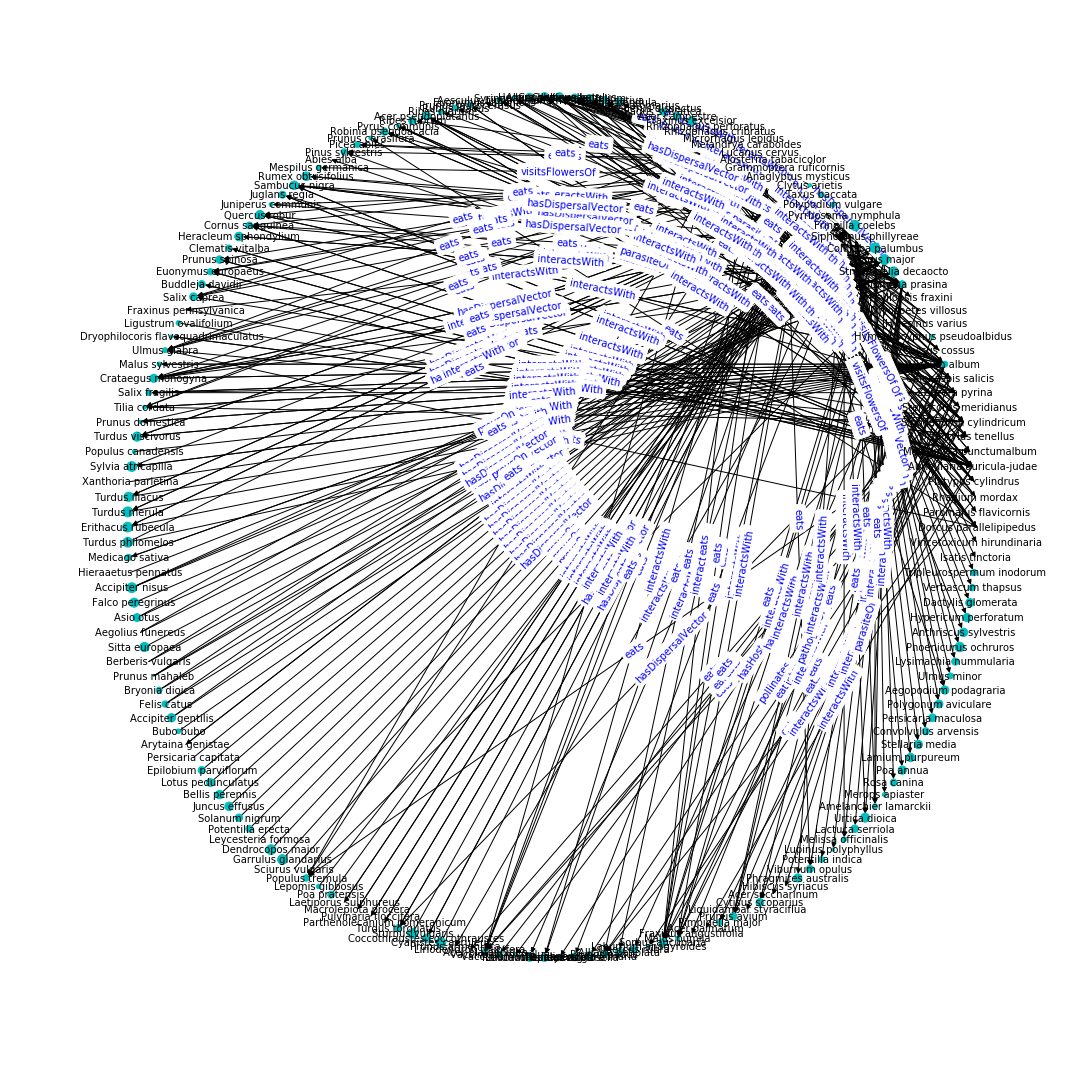

In [62]:
plt.figure(figsize=(15,15))
edge_labels = nx.get_edge_attributes(G,'label')

#pos = nx.spring_layout(G, iterations=50, k=50) 
#pos = nx.spring_layout(G)
#pos = nx.random_layout(G)
pos = nx.circular_layout(G)
#pos = nx.spectral_layout(G)
#pos = nx.shell_layout(G, scale=1)

nodeColors = nx.get_node_attributes(G,'color')

nx.draw_networkx_edge_labels(G,pos, edge_labels = edge_labels, font_size=10, font_color='blue')

#nx.draw_networkx_nodes(G, pos, node_color=nodeColors.values())

nx.draw_networkx(G, pos, with_labels=True, node_size = listOfNodeSizes, node_color='c', alpha= 1, arrows=True, 
                    linewidths=1, font_color="black", font_size=10, style = 'dashed')

plt.axis('off')
plt.tight_layout()
plt.show()

In [63]:
filename = "..\\docs\\"+taxon+country+".html"
with open(filename, "w") as file:
    file.write(" \
<!DOCTYPE html> \
<html> \
<head> \
<script src='cytoscape.min.js'></script> \
<script src='https://unpkg.com/layout-base/layout-base.js'></script> \
<script src='https://unpkg.com/cose-base/cose-base.js'></script> \
<script src='cytoscape-cose-bilkent.js'></script> \
</head> \
<style>#cy {width: 90%; height: 90%; position: absolute; top: 50px; left: 150px;}\
.red {color: red; font-style: bold;} \
.green {color: green; font-style: bold;} \
.blue {color: blue; font-style: bold;} \
.brown {color: brown; font-style: bold;} \
table, th, td {border: 1px solid black;} \
body {font-family: 'times; font-size: 6px;}\
</style> \
<body> \
<h1><em font-style: italic;>"+taxon+"</em> in "+country+"</h1>")

### Write out the details of the species

In [64]:
with open(filename, "a") as file:
    if len(G.nodes)==0:
        file.write("<p>No interacting species have been found for "+taxon+" in "+country+".</p>") 
    else:
        file.write("<p>Nodes and edges can be moved and if clicked, open a tab with species or interaction details</p>") 
        file.write("<p>The target species is the <SPAN CLASS='red'>red node</SPAN>. <em>Plantae</em> are <SPAN CLASS='green'>green</SPAN>, <em>Animalia</em> are <SPAN CLASS='blue'>blue</SPAN> and everything else is <SPAN CLASS='brown'>brown</SPAN></p>") 
        file.write("<p>Node area is proportional to the 1 km<sup>2</sup> occupancy</p>")
    

In [65]:
species = G.nodes
#with open(filename, "a") as file:
#    for n in species:
#        file.write("<tr><td><a target='_blank' href=https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+">"+n+"</a></td><td>"+str(dictOfNodeSizes[n])+"</td>\n")

In [66]:
with open(filename, "a") as file: 
    if len(sourceInteractions) != 0:
        file.write("<p>Below is a table of all <a href='https://www.globalbioticinteractions.org/'>GloBI</a> interaction records that <em>"+taxon+"</em> has with other taxa</p>")
        file.write("<table><th>Interaction</th><th>number</th>")
        for n in sourceInteractions:
            file.write("<tr><td><a target='_blank' href=https://www.globalbioticinteractions.org/?interactionType="+str(n[0])+"&sourceTaxon="+taxon.replace(" ", "%20")+">"+str(n[0])+"</a></td><td>"+str(n[1])+"</td>\n")
        file.write("</table>") 
    if len(targetInteractions) != 0:
        file.write("<p>Below is a table of all <a href='https://www.globalbioticinteractions.org/'>GloBI</a> interaction records that other taxa have with <em>"+taxon+"</em></p>")
        file.write("<table><th>Interaction</th><th>number</th>")
        for n in targetInteractions:
            file.write("<tr><td><a target='_blank' href=https://www.globalbioticinteractions.org/?interactionType="+str(n[0])+"&targetTaxon="+taxon.replace(" ", "%20")+">"+str(n[0])+"</a></td><td>"+str(n[1])+"</td>\n") 
        file.write("</table>")
    

In [67]:
file.close()

In [68]:
with open(filename, "a") as file:
    file.write(" \
<div id='cy'></div> \
<script> \
var cy = cytoscape({ \
  container: document.getElementById('cy'), \n \
  elements: [ \
")

### Write nodes to file

In [69]:
file = open(filename, "a")
for n in species:
    if n == taxon:
        file.write("{ data: { id: '"+n+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, selectable: true,},\n")
    else:
        file.write("{ data: { id: '"+n+"', kingdom: '"+kingdom[n]+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, selectable: false,},\n")
file.close()

### Write edges to file

In [70]:
file = open(filename, "a")
for edge in G.edges:
    file.write("{data: {id: '"+edge[0]+edge[1]+"', source: '"+edge[0]+"', target: '"+edge[1]+"', href: 'https://www.globalbioticinteractions.org/?interactionType="+str(nx.get_edge_attributes(G, 'label')[edge])+"&sourceTaxon="+edge[0]+"&targetTaxon="+edge[1]+"', label: '"+nx.get_edge_attributes(G, 'label')[edge]+"'}},\n")
file.close()
    

In [71]:
with open(filename, "a") as file:
    file.write("], \
style: [ \n\
        { \n\
            selector: 'node', \n\
            style: { \n\
                shape: 'circle', \n\
                'background-color': 'yellow', \n\
                label: 'data(id)', \n\
                'text-valign': 'center', \n\
                'font-family': 'helvetica', \n\
                'font-style': 'italic', \n\
                'font-size': '8px', \n\
                'border-width': '0.5', \n\
                'border-color': 'black', \n\
                'width': 'mapData(occnum, 0, 400, 3, 200)', \n\
                'height': 'mapData(occnum, 0, 400, 3, 200)' \n\
            } \n\
        },  \n\
        {  \n\
            selector: 'edge',  \n\
            style: {  \n\
                label: 'data(label)', \n\
                'font-family': 'helvetica', \n\
                'font-size': '6px', \n\
                'color': 'blue', \n\
                'curve-style': 'bezier', \n\
                'target-arrow-shape': 'triangle',  \n\
                'width': '1' \n\
                } \n\
         },  \n\
         {  \n\
              selector: '[kingdom = \"Plantae\"]',   \n\
              css: {  \n\
                'background-color': 'lightgreen'  \n\
                 }  \n\
        }, \n\
        {  \n\
              selector: '[kingdom = \"Animalia\"]',   \n\
              css: {  \n\
                'background-color': 'lightblue'  \n\
                 }  \n\
        }, \n\
        {  \n\
              selector: ':selected',   \n\
              css: {  \n\
                'line-color': 'red',  \n\
                'shape': 'square',  \n\
                'background-color': 'red'  \n\
                 }  \n\
        }], \n\
layout:  { \n\
            name: 'cose-bilkent', padding: 1, animate: true, gravity: 30, animationDuration: 3000 \n\
     } \n\
} \n\
); \n\
")

In [72]:
with open(filename, "a") as file:
    file.write("cy.userZoomingEnabled( true ); \n\
    cy.getElementById('"+taxon+"').select(); \n\
    document.write('<br />Degree of node <em>"+fullScientificName+"</em> = '+cy.getElementById('"+taxon+"').degree()); \n\
    cy.on('tap', 'node', function(){ \n\
        try { // your browser may block popups \n\
              window.open( this.data('href') ); \n\
            } catch(e){ // fall back on url change \n\
        window.location.href = this.data('href'); \n\
    } \n\
}); \n\
    cy.on('tap', 'edge', function(){  \n\
        try { // your browser may block popups  \n\
              window.open( this.data('href') );  \n\
            } catch(e){ // fall back on url change  \n\
        window.location.href = this.data('href'); \n\
    } \n\
}); \n\
</script> \n\
")

In [73]:
with open(filename, "a") as file:
    file.write("</ul> \
        <br /> \
        <br /> \
        <a href='https://github.com/AgentschapPlantentuinMeise/interactias'><img src='../images/Octocat.jpg' alt='GitHub logo' width='20'>Source code</a> \
        </body> \
        </html>")

In [74]:
file.close()

In [75]:
#with open(filename, "a") as file:
#    file.write("<h2>References</h2><ul>\n")

In [76]:
citations = cleanInteractDataTaxon['sourceCitation'].unique()
#file = open(filename, "a")
for ref in citations:
    print("* ",str(ref))
#    file.write("<li>"+str(ref)+"</li>\n")
#file.close()

*  A. Thessen. 2014. Species associations extracted from EOL text data objects via text mining.
*  Digital Bee Collections Network, 2014 (and updates). Version: 2015-03-18. National Science Foundation grant DBI 0956388; PBI: Phytophagous Insects as a Model Group for Documenting Planetary Biodiversity (Insecta: Heteroptera: Miridae: Orthotylinae, Phylinae). Version: 08 Mar 2016. National Science Foundation grant DBI#0316495; Tri-Trophic Thematic Collection Network, 2014 (and updates). Version: 08 Mar 2016. http://tcn.amnh.org/. National Science Foundation grant(s) EF#1115081, EF#1115103, EF#1115080, EF#1115144, EF#1115191, EF#1115104, EF#1115115
*  Jorrit H. Poelen. 2017. Species associations manually extracted from US National Cooperative Agricultural Pest Survey at <http://caps.ceris.purdue.edu/pest-lists>.
*  Brose, U. (2018). GlobAL daTabasE of traits and food Web Architecture (GATEWAy) version 1.0 [Data set]. German Centre for Integrative Biodiversity Research (iDiv) Halle-Jena-Lei

### For import into Gephi: A nodes and edges file has been replace by the .dot file format

In [77]:
write_dot(G, "..\\docs\\"+taxon+".dot")